In [11]:
from __future__ import division
import argparse
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models
import pandas as pd
import os
import pydicom
import numpy as np
import h5py
import time
from tqdm import tqdm as tqdm
import cv2
import pickle
from shutil import copyfile
from matplotlib import pyplot as plt
import seaborn as sns
import random

In [12]:
valid_samples = 26540
samples_per_split = 100000
train_samples = 70000

class KagglePEDataset(torch.utils.data.Dataset):
    """Kaggle PE dataset."""

    def __init__(self, csv_file, stage, transform=None, split=0):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.pedataframe = pd.read_csv(csv_file)
        self.pos_df = self.pedataframe[self.pedataframe.pe_present_on_image == 1]
        self.split_df = self.pedataframe[split*samples_per_split : (split+1)*samples_per_split]
        self.neg_df = self.split_df[self.split_df.pe_present_on_image == 0]
        self.transform = transform
        self.stage = stage
        
        # data is divided into sets of 100,000 2D slices
        #
        # Negative samples:
        # split 0,1,2,3,4,5 used for training
        # split 6,7 used for validation
        # pick 70,000 negative samples from the 100,000 slices (samples without replacement)
        #
        # Positive samples:
        # npy-pe-pos.hdf5
        # total 96,540 positive samples
        # pick 70,000 for training
        # 26,540 for validation
        #
        # For each dataset, combine the positive and negatives,then shuffle.
        
        self.split = split
        
        # copy file to scratch space on the fly
        # Uncomment for copy on the fly (only do this if not enough scraatch space)
        # copyfile('npy-' + str(split + 1) + '.hdf5', '/scratch/npy-' + str(split + 1) + '.hdf5')
        
        # sample 70,000 slices from this file
        self.split_hdf5_filename = '/scratch/npy-' + str(split + 1) + '.hdf5'
        self.pos_hdf5_filename = '/scratch/npy-pe-pos.hdf5'
    
    def destroy(self):
        ''' For copy on the fly (when scratch space insufficient)'''
        os.remove(self.filename )

    def __len__(self):
        """ Return number of 2D images. (Each CT slice is an independent image.)"""
        #return len(self.pedataframe)
        #return 100000
        #return num_pos_samples_per_dataset + num_neg_samples_per_dataset
    
    def get_class_weights(self):
        subset = self.pedataframe[:len(self)]
        pos = subset[subset.pe_present_on_image == 1]
        neg = subset[subset.pe_present_on_image == 0]
        return 1. / torch.tensor([len(neg), len(pos)], dtype=torch.float)
    
    def get_targets(self):
        subset = self.pedataframe[:len(self)]
        return torch.tensor(subset.pe_present_on_image, dtype=torch.long)
    
    def center_crop(self, crop_size, img):
        row = (img.shape[-2] - crop_size) // 2
        col = (img.shape[-1] - crop_size) // 2
        img = img[row : row + crop_size, col : col + crop_size]
        return img
    
    def random_crop(self, crop_size, img):
        row = random.randint(0, img.shape[-2] - crop_size)
        col = random.randint(0, img.shape[-1] - crop_size)
        img = img[row : row + crop_size, col : col + crop_size]
        return img
    
    def random_flip(self, img):
        r = random.randint(0,1)
        if r == 0:
            img = np.copy(np.flipud(img))
        return img

    def __getitem__(self, idx):
        ''' idx is index into dataframe. '''
        pe_present_on_image = int(self.pedataframe.pe_present_on_image[idx])
        data_identifier = self.pedataframe.StudyInstanceUID[idx] + \
            '/' + self.pedataframe.SOPInstanceUID[idx]
        
        if pe_present_on_image:
            # look for image in positive dataset
            h5py_file = h5py.File(self.pos_hdf5_filename, "r")
        else:
            # look for image in negative dataset
            h5py_file = h5py.File(self.split_hdf5_filename, "r")
        
        img = h5py_file[data_identifier][:]
        
        #resize 512x512 -> 256x256
        img = cv2.resize(img, (256,256), interpolation=cv2.INTER_AREA)
        
        # center crop 224
        if self.stage == 'train':
            img = self.random_crop(224, img)
            img = self.random_flip(img)
        else:
            img = self.center_crop(224, img)

        # unsqueeze to add channel dimension
        img = torch.tensor(img, dtype=torch.float).unsqueeze(0)
        h5py_file.close()
        
        return self.transform(img), torch.tensor(pe_present_on_image, dtype=torch.float), idx

In [13]:
def get_weighted_sampler(pe_dataset, stage='train'):

    assert len(pe_dataset.pos_df) == valid_samples + train_samples
    assert len(pe_dataset.split_df) == samples_per_split
    assert len(pe_dataset.neg_df) > train_samples
    
    if stage == 'train':
        pos_indices = np.array(pe_dataset.pos_df[:train_samples].index)
    else:
        pos_indices = np.array(pe_dataset.pos_df[train_samples:].index)
        
    neg_indices = np.array(pe_dataset.neg_df.index)
    np.random.shuffle(neg_indices)
    
    if stage == 'train':
        indices = np.concatenate((pos_indices, neg_indices[:train_samples]))
    else:
        indices = np.concatenate((pos_indices, neg_indices[:valid_samples]))
        
    np.random.shuffle(indices)
    sampler = torch.utils.data.SubsetRandomSampler(indices)
    
    if stage == 'train':
        assert len(sampler) == train_samples*2
    else:
        assert len(sampler) == valid_samples*2
    
    return sampler

In [14]:
def get_loaders(epoch):
    
    # Each epoch is 100,000 samples.
    # Rotate between 6 training sets and 2 validation sets.
    # (600,000 training samples and 200,000 validation samples)
    train_set_indices = [0, 1, 2, 3, 4, 5]
    valid_set_indices = [6, 7]

    # training dataset
    train_split = train_set_indices[epoch % len(train_set_indices)]
    print('Train split: ', train_split)
    dataset_train = KagglePEDataset(csv_file=train_csv, 
                                    stage='train', 
                                    transform=transform, 
                                    split=train_split)
    
    # Weighted sampler (to balance the dataset between positive and negative)
    train_sampler = get_weighted_sampler(dataset_train, stage='train')

    # training loader
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=16, 
        sampler=train_sampler, num_workers=1)
    
    # validation dataset
    valid_split = valid_set_indices[epoch % len(valid_set_indices)]
    print('Valid split: ', valid_split)
    dataset_valid = KagglePEDataset(csv_file=train_csv, 
                                    stage='valid',
                                    transform=transform, 
                                    split=valid_split)
    
    # validation loader
    valid_sampler = get_weighted_sampler(dataset_valid, stage='valid')
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=16, 
        sampler=valid_sampler, num_workers=1)
    
    return train_loader, valid_loader

***Begin Test Code***

In [15]:
data_dir = '/projectnb/ece601/kaggle-pulmonary-embolism/rsna-str-pulmonary-embolism-detection/'
train_csv = data_dir + 'train.csv'
train_dir = data_dir + 'train/'
train_df = pd.read_csv(train_csv)


In [16]:
global_mean = 0.0
global_std = 500.0
transform = T.Normalize(mean=[global_mean], std=[global_std])
pe_dataset = KagglePEDataset(csv_file=train_csv, stage='train', transform=transform, split=0)

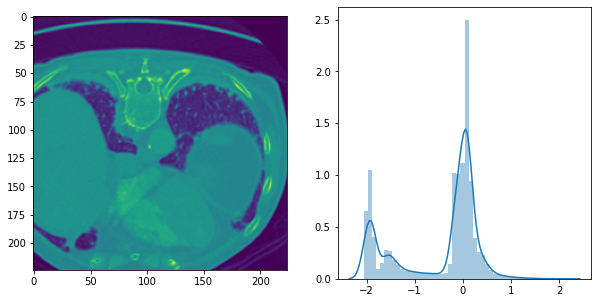

In [17]:
image, target, _ = pe_dataset[5]
image = image.squeeze(0)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(image)
sns.distplot(image.flatten(), ax=ax[1]);

In [18]:
get_weighted_sampler(pe_dataset, stage='train')
get_weighted_sampler(pe_dataset, stage='valid')

In [19]:
train_loader, valid_loader = get_loaders(33)

Train split:  3
Valid split:  7


In [ ]:
total_pos_samples = 0
bar = tqdm(train_loader)
for (data, target, _) in bar:
    total_pos_samples += sum(target)
    bar.set_description('')

In [ ]:
assert total_pos_samples == train_samples

In [ ]:
total_pos_samples = 0
bar = tqdm(valid_loader)
for (data, target, _) in bar:
    total_pos_samples += sum(target)
    bar.set_description('')

In [ ]:
assert total_pos_samples = = valid_samples

In [20]:
data_iter = iter(train_loader)
#data_iter = iter(valid_loader)
data, target, indices = next(data_iter)
print(target)
print(indices)
print(data.shape)

tensor([0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1.])
tensor([ 351713,  903644,  970446,  351644,  631994, 1292626,  734206,  304652,
         830725,  312507,  339853,  333832, 1139660,  376539,  712102, 1074695])
torch.Size([16, 1, 224, 224])


In [21]:
train_df.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [22]:
indices = indices.tolist()
for index in indices:
    print(train_df.pe_present_on_image[index])

0
1
1
0
1
1
1
0
1
0
0
0
1
0
1
1


In [23]:
def get_original_image(pedataframe,idx):
    img_name = os.path.join(train_dir,
                            pedataframe.StudyInstanceUID[idx],
                            pedataframe.SeriesInstanceUID[idx],
                            pedataframe.SOPInstanceUID[idx] + '.dcm')
    dicom_image = pydicom.dcmread(img_name) 

    try:
        # RuntimeError: The following handlers are available to decode the pixel ...
        # data however they are missing required dependencies: GDCM (req. GDCM)
        image = dicom_image.pixel_array
    except:
        print('Error parsing ', img_name)
        return None

    # in OSIC we find outside-scanner-regions with raw-values of -2000. 
    # Let's threshold between air (0) and this default (-2000) using -1000
    image[image <= -1000] = 0

     # convert to HU using DICOM information
    # HU is a number between -1000 and 1000 (generally)
    # good lung tissue is between -950 and -700 (approximately)
    intercept = dicom_image.RescaleIntercept
    slope = dicom_image.RescaleSlope

    if slope != 1:
        image = slope * image.astype(np.float64)

    image = image.astype(np.int16)
    image += np.int16(intercept)
    return image

In [24]:
data.shape

torch.Size([16, 1, 224, 224])

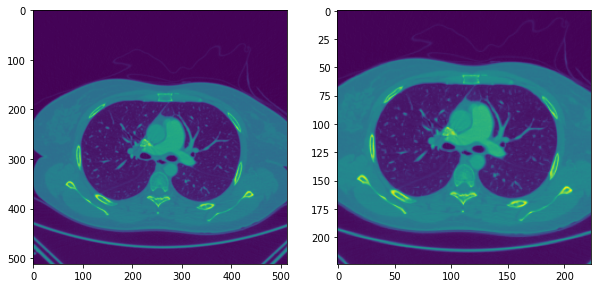

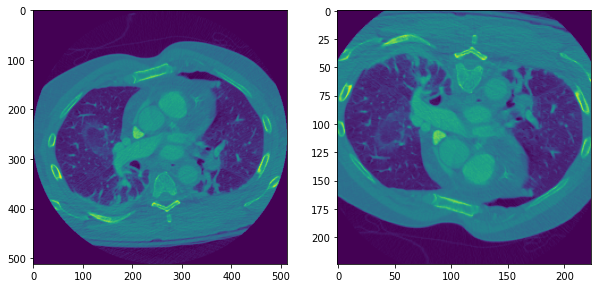

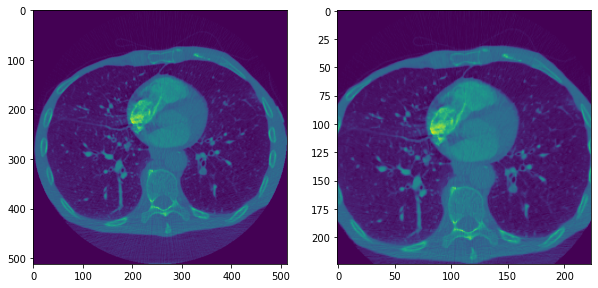

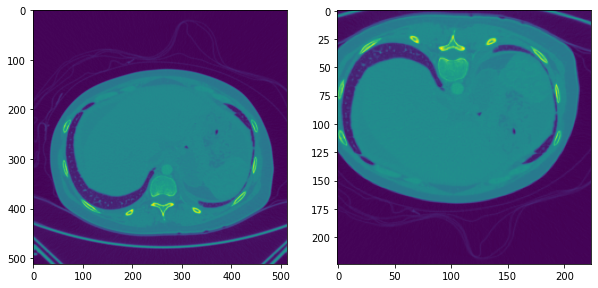

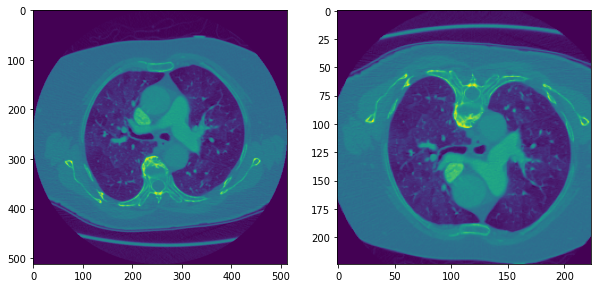

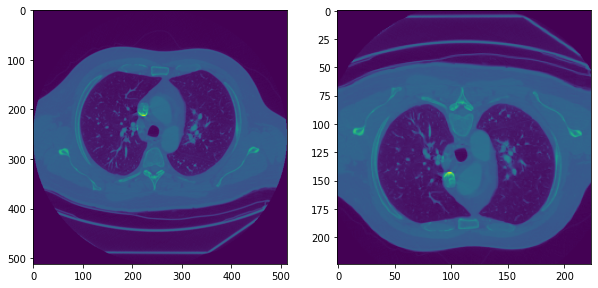

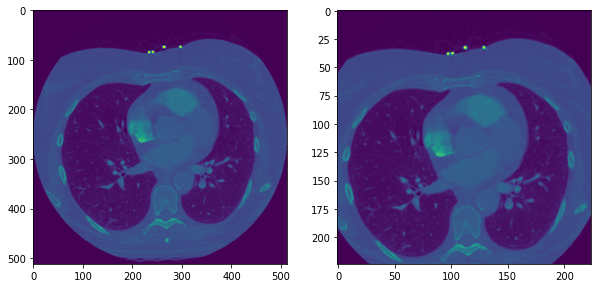

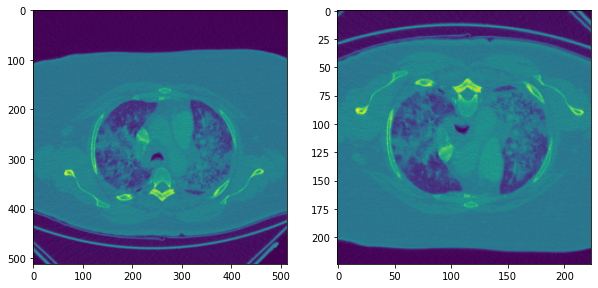

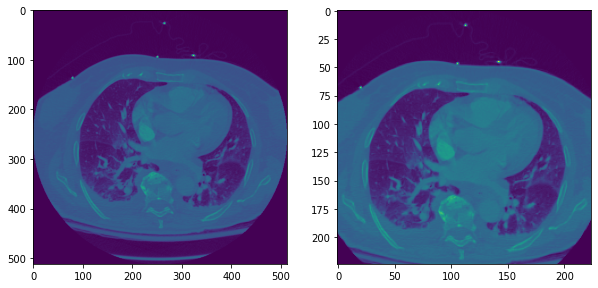

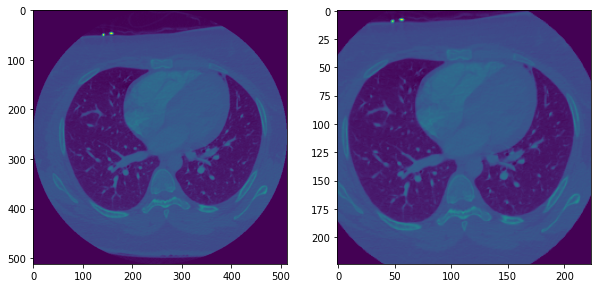

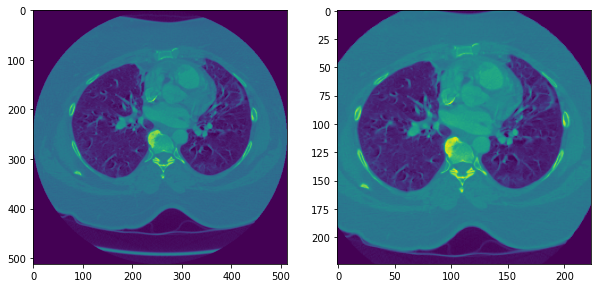

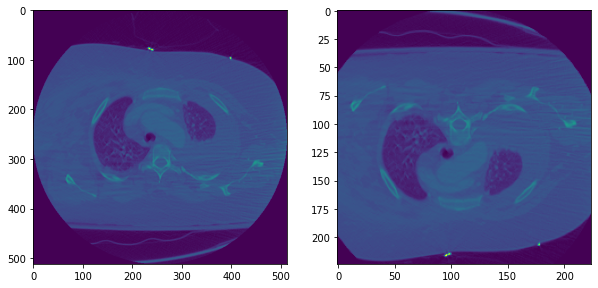

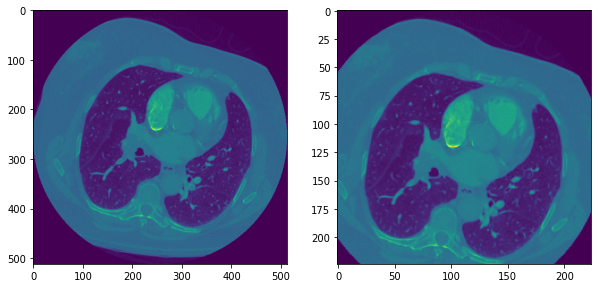

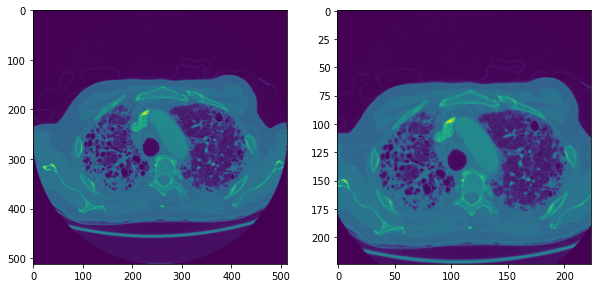

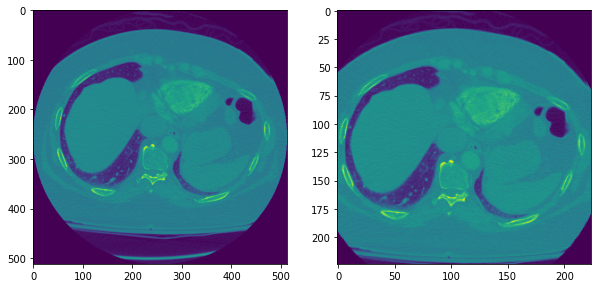

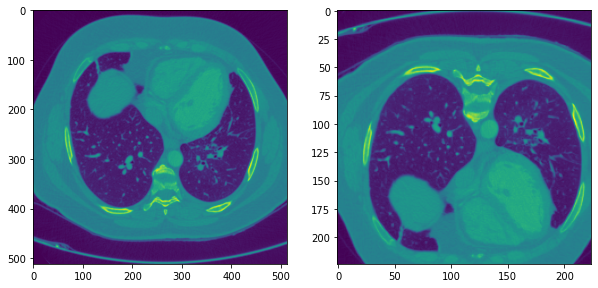

In [25]:
for i in range(len(indices)):
    index = indices[i]
    image = get_original_image(train_df, index)
    data_i = data[i,0,:,:]
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(image)
    ax[1].imshow(data_i)

***End Test Code***

In [28]:
bce = torch.nn.BCEWithLogitsLoss()
def criterion(logits, target):
    loss = bce(logits.view(-1), target.view(-1))
    return loss

In [29]:
def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target, _) in bar:
        data, target = data.to(device), target.to(device)
        
        # zero gradients
        optimizer.zero_grad()

        #forward pass
        logits = model(data.float())
        
        # calculate loss
        loss = criterion(logits, target)

        # backpropagate the loss (backward pass)
        loss.backward()
 
        # update parameters based on accumulated gradients
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()

        train_loss.append(loss_np)
        average_loss = sum(train_loss) / len(train_loss)
        bar.set_description('loss: %.5f, mean: %.5f' % (loss_np, average_loss))
    return float(average_loss)

def valid_epoch(model, loader):
    model.eval()
    val_loss = []
    pos_logits = []
    neg_logits = []

    with torch.no_grad():
        for (data, target, _) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            loss_np = loss.detach().cpu().numpy()

            val_loss.append(loss_np)
            
            for i in range(logits.shape[-1]):
                b = target[i].detach().cpu().numpy()
                if b == 1:
                    pos_logits.append(logits[i].detach().cpu().numpy())
                else:
                    neg_logits.append(logits[i].detach().cpu().numpy())
                    
    val_loss = sum(val_loss) / len(val_loss)
    
    neg_logits_tensor = torch.FloatTensor(neg_logits).cuda()
    pos_logits_tensor = torch.FloatTensor(pos_logits).cuda()
    
    neg_loss = criterion(neg_logits_tensor, torch.zeros(neg_logits_tensor.shape).float().cuda())
    pos_loss = criterion(pos_logits_tensor, torch.ones(pos_logits_tensor.shape).float().cuda())
    
    neg_loss = neg_loss.detach().cpu().numpy()
    pos_loss = pos_loss.detach().cpu().numpy()
    
    neg_mean = float(torch.sigmoid(neg_logits_tensor).mean().detach().cpu().numpy())
    pos_mean = float(torch.sigmoid(pos_logits_tensor).mean().detach().cpu().numpy())
    
    return float(val_loss), float(pos_loss), float(neg_loss), pos_mean, neg_mean

In [36]:
resnext101 = models.resnext50_32x4d(pretrained=True, progress=True)
resnext101.fc = torch.nn.Linear(resnext101.fc.in_features, 1)
resnext101.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [37]:
def get_optimizer(lr, model):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
    return optimizer

In [38]:
init_lr = 0.1
n_epochs = 40
device = 'cuda'

# reduce LR by gamma three times every 10 epochs
# each epoch is 100,000 samples
gamma = 10
schedule = [10, 20, 30]

model = resnext101.to(device)
optimizer = get_optimizer(init_lr, model)

master_train_loss = []
master_valid_loss = []
epoch = 1
#best_valid_loss = 10

global_mean = 0.0
global_std = 500.0
transform = T.Normalize(mean=[global_mean], std=[global_std])

In [39]:
print(optimizer.param_groups[0]["lr"])
print(optimizer)

0.1
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)


In [40]:
while epoch <= n_epochs:
    print(time.ctime(), 'Epoch:', epoch)
    
    # update learning rate 
    if epoch in schedule:
        new_lr = optimizer.param_groups[0]["lr"] / gamma
        optimizer = get_optimizer(new_lr, model)
    
    train_loader, valid_loader = get_loaders(epoch)

    # train
    train_loss = train_epoch(model, train_loader, optimizer)
    optimizer.zero_grad()
    
    # validate
    valid_loss, pos_loss, neg_loss, pos_mean, neg_mean = valid_epoch(model, valid_loader)
    
    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, valid loss: {(valid_loss):.5f}'
    print(content)
    content = f'pos loss: {(pos_loss):.5f}, neg loss: {(neg_loss):.5f}, pos mean: {(pos_mean):.5f}, neg mean {(neg_mean):.5f}'
    print(content)
    master_train_loss.append(train_loss)
    master_valid_loss.append(valid_loss)
    
    # save loss data and model weights
    with open('train_loss.pkl', 'wb') as f:
        pickle.dump(master_train_loss, f)
    with open('valid_loss.pkl', 'wb') as f:
        pickle.dump(master_valid_loss, f)
        
        torch.save(model.state_dict(), 'model-resnext-50-{}.pth'.format(epoch))
        best_valid_loss = valid_loss
    
    epoch += 1
    
    # clean up scratch
    # dataset_train.destroy()
    # dataset_valid.destroy()
        

Fri Nov 27 10:33:09 2020 Epoch: 1
Train split:  1
Valid split:  7


100%|██████████| 3318/3318 [03:10<00:00, 17.45it/s]


Fri Nov 27 11:12:36 2020 Epoch 1, lr: 0.1000000, train loss: 0.53686, valid loss: 0.46606
pos loss: 0.30926, neg loss: 0.62886, pos mean: 0.75887, neg mean 0.35456
Fri Nov 27 11:12:36 2020 Epoch: 2
Train split:  2
Valid split:  6


100%|██████████| 3318/3318 [03:08<00:00, 17.65it/s]


Fri Nov 27 11:51:59 2020 Epoch 2, lr: 0.1000000, train loss: 0.47372, valid loss: 0.45562
pos loss: 0.34378, neg loss: 0.54767, pos mean: 0.72505, neg mean 0.33322
Fri Nov 27 11:51:59 2020 Epoch: 3
Train split:  3
Valid split:  7


100%|██████████| 3318/3318 [03:10<00:00, 17.41it/s]


Fri Nov 27 12:31:25 2020 Epoch 3, lr: 0.1000000, train loss: 0.46798, valid loss: 0.47807
pos loss: 0.46341, neg loss: 0.52159, pos mean: 0.67034, neg mean 0.31119
Fri Nov 27 12:31:25 2020 Epoch: 4
Train split:  4
Valid split:  6


100%|██████████| 3318/3318 [03:09<00:00, 17.51it/s]


Fri Nov 27 13:10:57 2020 Epoch 4, lr: 0.1000000, train loss: 0.47152, valid loss: 0.50114
pos loss: 0.69152, neg loss: 0.29069, pos mean: 0.54616, neg mean 0.20657
Fri Nov 27 13:10:58 2020 Epoch: 5
Train split:  5
Valid split:  7


100%|██████████| 3318/3318 [03:08<00:00, 17.59it/s]


Fri Nov 27 13:50:23 2020 Epoch 5, lr: 0.1000000, train loss: 0.47035, valid loss: 0.47723
pos loss: 0.51825, neg loss: 0.44193, pos mean: 0.61644, neg mean 0.30033
Fri Nov 27 13:50:24 2020 Epoch: 6
Train split:  0
Valid split:  6


100%|██████████| 3318/3318 [03:09<00:00, 17.47it/s]


Fri Nov 27 14:29:58 2020 Epoch 6, lr: 0.1000000, train loss: 0.44485, valid loss: 0.51218
pos loss: 0.71891, neg loss: 0.29758, pos mean: 0.55365, neg mean 0.20544
Fri Nov 27 14:29:58 2020 Epoch: 7
Train split:  1
Valid split:  7


100%|██████████| 3318/3318 [03:10<00:00, 17.44it/s]


Fri Nov 27 15:09:35 2020 Epoch 7, lr: 0.1000000, train loss: 0.45970, valid loss: 0.45471
pos loss: 0.42271, neg loss: 0.49056, pos mean: 0.68217, neg mean 0.31016
Fri Nov 27 15:09:35 2020 Epoch: 8
Train split:  2
Valid split:  6


100%|██████████| 3318/3318 [03:10<00:00, 17.43it/s]


Fri Nov 27 15:49:10 2020 Epoch 8, lr: 0.1000000, train loss: 0.45305, valid loss: 0.51455
pos loss: 0.19494, neg loss: 0.80654, pos mean: 0.84407, neg mean 0.38777
Fri Nov 27 15:49:10 2020 Epoch: 9
Train split:  3
Valid split:  7


100%|██████████| 3318/3318 [03:10<00:00, 17.44it/s]


Fri Nov 27 16:28:45 2020 Epoch 9, lr: 0.1000000, train loss: 0.45297, valid loss: 0.46952
pos loss: 0.40747, neg loss: 0.53483, pos mean: 0.71209, neg mean 0.29202
Fri Nov 27 16:28:45 2020 Epoch: 10
Train split:  4
Valid split:  6


100%|██████████| 3318/3318 [03:10<00:00, 17.44it/s]


Fri Nov 27 17:08:27 2020 Epoch 10, lr: 0.0100000, train loss: 0.42503, valid loss: 0.42764
pos loss: 0.33061, neg loss: 0.56077, pos mean: 0.75309, neg mean 0.32375
Fri Nov 27 17:08:27 2020 Epoch: 11
Train split:  5
Valid split:  7


100%|██████████| 3318/3318 [03:10<00:00, 17.46it/s]


Fri Nov 27 17:48:09 2020 Epoch 11, lr: 0.0100000, train loss: 0.41702, valid loss: 0.42857
pos loss: 0.47474, neg loss: 0.38592, pos mean: 0.66514, neg mean 0.25567
Fri Nov 27 17:48:09 2020 Epoch: 12
Train split:  0
Valid split:  6


100%|██████████| 3318/3318 [03:08<00:00, 17.62it/s]


Fri Nov 27 18:27:50 2020 Epoch 12, lr: 0.0100000, train loss: 0.38283, valid loss: 0.47545
pos loss: 0.41734, neg loss: 0.52132, pos mean: 0.72845, neg mean 0.29710
Fri Nov 27 18:27:50 2020 Epoch: 13
Train split:  1
Valid split:  7


100%|██████████| 3318/3318 [03:12<00:00, 17.23it/s]


Fri Nov 27 19:07:39 2020 Epoch 13, lr: 0.0100000, train loss: 0.40333, valid loss: 0.41374
pos loss: 0.39876, neg loss: 0.40639, pos mean: 0.71487, neg mean 0.25597
Fri Nov 27 19:07:39 2020 Epoch: 14
Train split:  2
Valid split:  6


100%|██████████| 3318/3318 [03:11<00:00, 17.32it/s]


Fri Nov 27 19:47:29 2020 Epoch 14, lr: 0.0100000, train loss: 0.39092, valid loss: 0.40806
pos loss: 0.29831, neg loss: 0.47784, pos mean: 0.78949, neg mean 0.27061
Fri Nov 27 19:47:30 2020 Epoch: 15
Train split:  3
Valid split:  7


100%|██████████| 3318/3318 [03:10<00:00, 17.45it/s]


Fri Nov 27 20:27:18 2020 Epoch 15, lr: 0.0100000, train loss: 0.38532, valid loss: 0.41622
pos loss: 0.30476, neg loss: 0.56643, pos mean: 0.78859, neg mean 0.31457
Fri Nov 27 20:27:18 2020 Epoch: 16
Train split:  4
Valid split:  6


100%|██████████| 3318/3318 [03:08<00:00, 17.56it/s]


Fri Nov 27 21:06:56 2020 Epoch 16, lr: 0.0100000, train loss: 0.38517, valid loss: 0.43416
pos loss: 0.56604, neg loss: 0.28766, pos mean: 0.62560, neg mean 0.20030
Fri Nov 27 21:06:57 2020 Epoch: 17
Train split:  5
Valid split:  7


100%|██████████| 3318/3318 [03:09<00:00, 17.53it/s]


Fri Nov 27 21:46:34 2020 Epoch 17, lr: 0.0100000, train loss: 0.38703, valid loss: 0.43889
pos loss: 0.50979, neg loss: 0.35253, pos mean: 0.66136, neg mean 0.23445
Fri Nov 27 21:46:35 2020 Epoch: 18
Train split:  0
Valid split:  6


100%|██████████| 3318/3318 [03:09<00:00, 17.49it/s]


Fri Nov 27 22:26:12 2020 Epoch 18, lr: 0.0100000, train loss: 0.35233, valid loss: 0.46603
pos loss: 0.29953, neg loss: 0.62193, pos mean: 0.80454, neg mean 0.32141
Fri Nov 27 22:26:12 2020 Epoch: 19
Train split:  1
Valid split:  7


100%|██████████| 3318/3318 [03:08<00:00, 17.58it/s]


Fri Nov 27 23:05:45 2020 Epoch 19, lr: 0.0100000, train loss: 0.37434, valid loss: 0.49651
pos loss: 0.20589, neg loss: 0.80175, pos mean: 0.85702, neg mean 0.36404
Fri Nov 27 23:05:45 2020 Epoch: 20
Train split:  2
Valid split:  6


100%|██████████| 3318/3318 [03:09<00:00, 17.51it/s]


Fri Nov 27 23:45:16 2020 Epoch 20, lr: 0.0010000, train loss: 0.34414, valid loss: 0.39978
pos loss: 0.39949, neg loss: 0.39212, pos mean: 0.75430, neg mean 0.22655
Fri Nov 27 23:45:16 2020 Epoch: 21
Train split:  3
Valid split:  7


100%|██████████| 3318/3318 [03:09<00:00, 17.49it/s]


Sat Nov 28 00:24:47 2020 Epoch 21, lr: 0.0010000, train loss: 0.32789, valid loss: 0.40308
pos loss: 0.43043, neg loss: 0.38446, pos mean: 0.74436, neg mean 0.21780
Sat Nov 28 00:24:47 2020 Epoch: 22
Train split:  4
Valid split:  6


100%|██████████| 3318/3318 [03:09<00:00, 17.54it/s]


Sat Nov 28 01:04:15 2020 Epoch 22, lr: 0.0010000, train loss: 0.32253, valid loss: 0.40127
pos loss: 0.52858, neg loss: 0.30020, pos mean: 0.69400, neg mean 0.19181
Sat Nov 28 01:04:16 2020 Epoch: 23
Train split:  5
Valid split:  7


100%|██████████| 3318/3318 [03:10<00:00, 17.44it/s]


Sat Nov 28 01:43:43 2020 Epoch 23, lr: 0.0010000, train loss: 0.31766, valid loss: 0.39618
pos loss: 0.38384, neg loss: 0.38513, pos mean: 0.76448, neg mean 0.22148
Sat Nov 28 01:43:44 2020 Epoch: 24
Train split:  0
Valid split:  6


100%|██████████| 3318/3318 [03:10<00:00, 17.45it/s]


Sat Nov 28 02:23:12 2020 Epoch 24, lr: 0.0010000, train loss: 0.28840, valid loss: 0.42999
pos loss: 0.47653, neg loss: 0.36109, pos mean: 0.73874, neg mean 0.21002
Sat Nov 28 02:23:12 2020 Epoch: 25
Train split:  1
Valid split:  7


100%|██████████| 3318/3318 [03:10<00:00, 17.43it/s]


Sat Nov 28 03:02:42 2020 Epoch 25, lr: 0.0010000, train loss: 0.29641, valid loss: 0.40512
pos loss: 0.39293, neg loss: 0.37874, pos mean: 0.77370, neg mean 0.20814
Sat Nov 28 03:02:42 2020 Epoch: 26
Train split:  2
Valid split:  6


100%|██████████| 3318/3318 [03:10<00:00, 17.38it/s]


Sat Nov 28 03:42:14 2020 Epoch 26, lr: 0.0010000, train loss: 0.29636, valid loss: 0.41680
pos loss: 0.44853, neg loss: 0.41854, pos mean: 0.75497, neg mean 0.22514
Sat Nov 28 03:42:14 2020 Epoch: 27
Train split:  3
Valid split:  7


100%|██████████| 3318/3318 [03:10<00:00, 17.39it/s]


Sat Nov 28 04:21:47 2020 Epoch 27, lr: 0.0010000, train loss: 0.28491, valid loss: 0.43075
pos loss: 0.51233, neg loss: 0.40048, pos mean: 0.72902, neg mean 0.22050
Sat Nov 28 04:21:47 2020 Epoch: 28
Train split:  4
Valid split:  6


100%|██████████| 3318/3318 [03:10<00:00, 17.40it/s]


Sat Nov 28 05:01:21 2020 Epoch 28, lr: 0.0010000, train loss: 0.28363, valid loss: 0.39335
pos loss: 0.42887, neg loss: 0.39361, pos mean: 0.76756, neg mean 0.20447
Sat Nov 28 05:01:21 2020 Epoch: 29
Train split:  5
Valid split:  7


100%|██████████| 3318/3318 [03:09<00:00, 17.47it/s]


Sat Nov 28 05:40:54 2020 Epoch 29, lr: 0.0010000, train loss: 0.28037, valid loss: 0.45466
pos loss: 0.56205, neg loss: 0.35953, pos mean: 0.72500, neg mean 0.19239
Sat Nov 28 05:40:54 2020 Epoch: 30
Train split:  0
Valid split:  6


100%|██████████| 3318/3318 [03:10<00:00, 17.39it/s]


Sat Nov 28 06:20:34 2020 Epoch 30, lr: 0.0001000, train loss: 0.26886, valid loss: 0.44752
pos loss: 0.60592, neg loss: 0.34293, pos mean: 0.71822, neg mean 0.19264
Sat Nov 28 06:20:34 2020 Epoch: 31
Train split:  1
Valid split:  7


100%|██████████| 3318/3318 [03:10<00:00, 17.41it/s]


Sat Nov 28 07:00:11 2020 Epoch 31, lr: 0.0001000, train loss: 0.27038, valid loss: 0.42015
pos loss: 0.50008, neg loss: 0.33237, pos mean: 0.75584, neg mean 0.18663
Sat Nov 28 07:00:12 2020 Epoch: 32
Train split:  2
Valid split:  6


100%|██████████| 3318/3318 [03:11<00:00, 17.36it/s]


Sat Nov 28 07:39:49 2020 Epoch 32, lr: 0.0001000, train loss: 0.26476, valid loss: 0.42860
pos loss: 0.60731, neg loss: 0.25581, pos mean: 0.70483, neg mean 0.15848
Sat Nov 28 07:39:49 2020 Epoch: 33
Train split:  3
Valid split:  7


100%|██████████| 3318/3318 [03:10<00:00, 17.41it/s]


Sat Nov 28 08:19:26 2020 Epoch 33, lr: 0.0001000, train loss: 0.24762, valid loss: 0.45166
pos loss: 0.57884, neg loss: 0.32924, pos mean: 0.74815, neg mean 0.18149
Sat Nov 28 08:19:26 2020 Epoch: 34
Train split:  4
Valid split:  6


100%|██████████| 3318/3318 [03:10<00:00, 17.40it/s]


Sat Nov 28 08:59:00 2020 Epoch 34, lr: 0.0001000, train loss: 0.24480, valid loss: 0.41619
pos loss: 0.56047, neg loss: 0.25825, pos mean: 0.73238, neg mean 0.15156
Sat Nov 28 08:59:01 2020 Epoch: 35
Train split:  5
Valid split:  7


loss: 0.10763, mean: 0.16455:   0%|          | 16/8750 [00:04<39:46,  3.66it/s]


KeyboardInterrupt: 

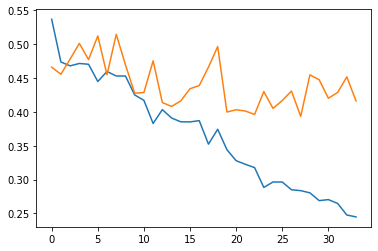

In [42]:
plt.plot(master_train_loss[:], label='train')
plt.plot(master_valid_loss[:], label='valid')